In [1]:
"""
Tutorial: Predicting Daily Bike Rentals using an LSTM Network

Overview:
This tutorial demonstrates how to predict daily bike rental counts using an LSTM (Long Short-Term Memory)
network. We use the Bike Sharing Dataset ("day.csv") from the UCI repository. The project covers data loading,
time series preprocessing (using sliding windows), building and training an LSTM model with early stopping,
and evaluating performance with creative and interactive visualizations (including an interactive Plotly line chart,
a calendar heatmap of residuals, and a 3D scatter plot of predictions vs. actuals).

"""

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # For interactive plots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Use a different matplotlib style
plt.style.use("ggplot")
sns.set_theme(style="white", palette="coolwarm")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# 1. Data Loading and Preprocessing
# Load the Bike Sharing Dataset (daily version)
data = pd.read_csv("/content/day.csv")  # Ensure day.csv is in the working directory
print("Dataset shape:", data.shape)
print("Dataset preview:")
data.head()

Dataset shape: (731, 16)
Dataset preview:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
# Convert date column to datetime and sort
data['dteday'] = pd.to_datetime(data['dteday'])
data.sort_values('dteday', inplace=True)

In [10]:
# Select features for our model
# We'll use a subset of features: 'temp', 'hum', 'windspeed', 'weathersit', 'holiday', 'workingday' and target 'cnt'
features = ['temp', 'hum', 'windspeed', 'weathersit', 'holiday', 'workingday']
target = 'cnt'

In [11]:
# For simplicity, convert 'weathersit', 'holiday', 'workingday' to categorical if not already
data['weathersit'] = data['weathersit'].astype('category')
data['holiday'] = data['holiday'].astype('category')
data['workingday'] = data['workingday'].astype('category')

In [12]:
data_model = pd.get_dummies(data[features + [target]], columns=['weathersit', 'holiday', 'workingday'], drop_first=True)

In [13]:
print("\nColumns after encoding:")
data_model.columns


Columns after encoding:


Index(['temp', 'hum', 'windspeed', 'cnt', 'weathersit_2', 'weathersit_3',
       'holiday_1', 'workingday_1'],
      dtype='object')

In [14]:
# 2. Creating Time Series Sequences
# We will use a sliding window of 7 days to predict the next day's bike count.
def create_sequences(df, window_size=7):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq_x = df.iloc[i:i+window_size].drop(columns=[target]).values
        seq_y = df.iloc[i+window_size][target]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [15]:
# We use the entire dataset (after encoding) and then later split into train/test.
X_seq, y_seq = create_sequences(data_model, window_size=7)
print("\nSequence data shape:", X_seq.shape, y_seq.shape)


Sequence data shape: (724, 7, 7) (724,)


In [16]:
# 3. Train-Test Split and Scaling
# Split sequences into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.20, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Training set shape: (579, 7, 7)
Test set shape: (145, 7, 7)


In [17]:
# Flatten sequence data for scaling (scale each feature individually over all timesteps)
num_timesteps = X_train.shape[1]
num_features = X_train.shape[2]
X_train_flat = X_train.reshape(-1, num_features)
X_test_flat = X_test.reshape(-1, num_features)

In [18]:
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_test_flat_scaled = scaler.transform(X_test_flat)

# Reshape back to original sequence shape
X_train_scaled = X_train_flat_scaled.reshape(X_train.shape)
X_test_scaled = X_test_flat_scaled.reshape(X_test.shape)

In [19]:
# 4. Building the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape, activation='tanh'),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(25, activation='tanh'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(10, activation='relu'),
        Dense(1)  # Linear output for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
lstm_model = build_lstm_model(input_shape)
lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 50)               │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 50)               │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25)                  │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,771 (77.23 KB)

 Trainable params: 19,621 (76.64 KB)

 Non-trainable params: 150 (600.00 B)

In [20]:
# 5. Training the Model with Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
history = lstm_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 25343980.0000 - val_loss: 21869150.0000
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26745124.0000 - val_loss: 21866618.0000
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24888220.0000 - val_loss: 21862422.0000
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 25550450.0000 - val_loss: 21856484.0000
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 26490396.0000 - val_loss: 21849182.0000
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26182304.0000 - val_loss: 21839954.0000
Epoch 7/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26115316.0000 - val_loss: 21826758.0000
Epoch 8/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24793932.0000 - val_loss: 21808022.0000
Epoch 9/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24786038.0000 - val_loss: 21789626.0000
Epoch 10/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25391828.0000 - val_loss: 21767620.0000

In [21]:
# 6. Model Evaluation
y_pred = lstm_model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nTest MSE: {mse:.3f}")
print(f"Test R2 Score: {r2:.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step

Test MSE: 1815146.625
Test R2 Score: 0.434


In [22]:
# 7. Advanced and Creative Visualizations

# 7.1 Interactive Plotly Line Chart for Actual vs. Predicted Bike Counts
# We'll plot the first 50 test examples as an interactive line chart.
test_index = np.arange(len(y_test))
df_results = pd.DataFrame({
    "Index": test_index,
    "Actual": y_test,
    "Predicted": y_pred
})

In [23]:
fig = px.line(df_results, x="Index", y=["Actual", "Predicted"],
              title="Interactive Plot: Actual vs. Predicted Bike Counts (Test Set)",
              markers=True)
fig.update_layout(yaxis_title="Bike Rental Count")
fig.show()

In [24]:
# 7.2 Calendar Heatmap of Residuals
# Compute residuals and create a calendar heatmap for the test set (assuming test set dates are sequential)
residuals = y_test - y_pred
# Create a date range for visualization (assume daily frequency starting from an arbitrary date)
date_range = pd.date_range(start="2020-01-01", periods=len(y_test), freq="D")
df_resid = pd.DataFrame({"Date": date_range, "Residual": residuals})
df_resid["Residual_abs"] = df_resid["Residual"].abs()

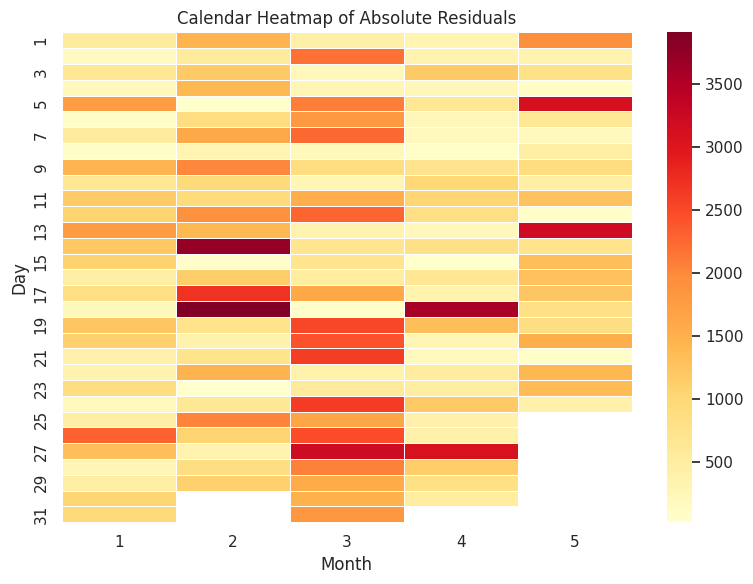

In [28]:
# Pivot table for a simple calendar heatmap (group by month-day)
df_resid['Month'] = df_resid['Date'].dt.month
df_resid['Day'] = df_resid['Date'].dt.day
heatmap_data = df_resid.pivot(index="Day", columns="Month", values="Residual_abs")
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, annot=False)
plt.title("Calendar Heatmap of Absolute Residuals")
plt.xlabel("Month")
plt.ylabel("Day")
plt.tight_layout()
plt.show()

In [26]:
# 7.3 3D Scatter Plot for Predictions vs. Actuals and Residuals
# Use Plotly's 3D scatter plot for an interactive visualization.
fig3d = px.scatter_3d(
    df_results, x="Actual", y="Predicted", z=residuals,
    color=residuals, color_continuous_scale='Viridis',
    title="3D Scatter Plot: Actual, Predicted, and Residuals"
)
fig3d.update_layout(scene=dict(
    xaxis_title="Actual Count",
    yaxis_title="Predicted Count",
    zaxis_title="Residual"
))
fig3d.show()


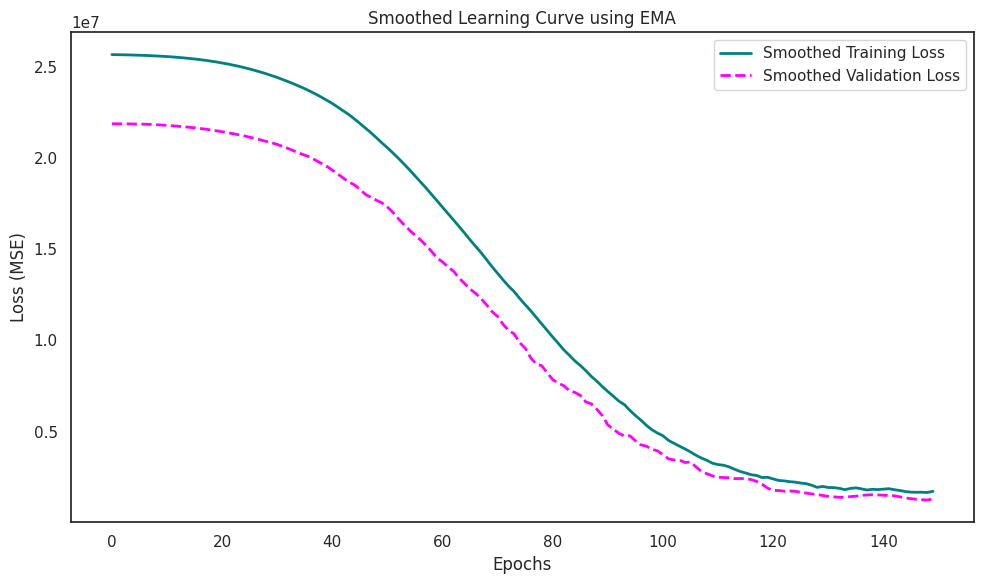

In [27]:
# 7.4 Smoothed Training Curve with Exponential Moving Average (EMA)
loss_df = pd.DataFrame(history.history)
loss_df['EMA_train_loss'] = loss_df['loss'].ewm(span=5, adjust=False).mean()
loss_df['EMA_val_loss'] = loss_df['val_loss'].ewm(span=5, adjust=False).mean()
plt.figure(figsize=(10,6))
plt.plot(loss_df['EMA_train_loss'], label='Smoothed Training Loss', linestyle='-', color='teal', linewidth=2)
plt.plot(loss_df['EMA_val_loss'], label='Smoothed Validation Loss', linestyle='--', color='magenta', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Smoothed Learning Curve using EMA")
plt.legend()
plt.tight_layout()
plt.show()